# Machine learning

Ce Notebook va permettre d'appliquer des algorithme de clustering à notre dataframe nettoyé : df_ml.

On souhaite regrouper les avis subjectifs des consommateurs en clusters, en utilisant différents features parmi lesquels : look, smell, taste, feel et l'abv. Chacun des ces clusters sera censé représenté un "type" de consommateur. On aura alors le chois dans l'exploitation des résultats : prédiction des notes subjectives à partir des habitudes du consommateur, recommendation de bières... 

On se propose de tester 3 algorithmes de clustering différent et d'observer leurs résultats relatifs : Kmean, CAH et DBSCAN. Voilà commennt nous allons procéder : 

- Clustering sur la table df_ml et df_subj_abv (df_ml à laquelle on retire les lignes sans avis) pour regrouper les bières en cluster selon tous les features puis selon les 4 critères subjectifs smell, taste, look et feel.
- Réalisation d'une matrice de corrélation afin d'effectuer de nouveaux clusterings sur les features les plus corrélés (on cherche à regrouper les bières selon leurs similitudes et on préfère donc cette approche à un clustering sur les features les moins corrélés entre-eux).
- Comparaison des résultats avec les autres algorithmes de clustering utilisés.

In [2]:
# Importation des modules nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# Importation des données 
df_ml = pd.read_csv(r'C:\Users\sim13\OneDrive\Documents\Projet_python_2A\data_avis_subj.csv')
df_ml

,id,beer_name,beer_style,abv,brewery_id,brewery_name,look,smell,taste,feel
0,8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.0,3.5,4.0,3.5
1,8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.5,3.0,3.5,4.0
2,8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.0,3.5,4.0,3.5
3,8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.0,4.0,4.0,4.5
4,8749,Pleasanton Pale Ale,American Pale Ale (APA),5.3,2199,Main Street Brewery,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
8493605,167034,Vals Paterke,Belgian Strong Pale Ale,8.3,40028,Brouwerij 't Drankorgel,NaN,NaN,NaN,NaN
8493606,214214,Crus - Sacra Birra,Belgian Dubbel,7.0,44211,Birrificio Artigianale Opera,NaN,NaN,NaN,NaN
8493607,200378,Caudillo India Pale Ale,English India Pale Ale (IPA),8.3,43193,Cerveza Caudillo,NaN,NaN,NaN,NaN
8493608,289252,Hellegat Blond,Belgian Blonde Ale,6.5,49596,Brouwerij De Klem,NaN,NaN,NaN,NaN


In [4]:
# On se rappelle qu'on avait choisi de garder les lignes des bières sans avis mais dont l'abv était connu
df_ml.isnull().sum()

id                    0
beer_name             0
beer_style            0
abv                   0
brewery_id            0
brewery_name          0
look            3535815
smell           3535815
taste           3535815
feel            3535815
dtype: int64

On crée un dataset sans valeurs manquantes.

In [7]:
df_subj_abv = df_ml.dropna()
df_subj_abv.describe()

# On reset l'index et on supprime l'ancien 
df_subj_abv = df_subj_abv.reset_index()
df_subj_abv.drop(columns = 'index')

,id,beer_name,beer_style,abv,brewery_id,brewery_name,look,smell,taste,feel
0,8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.00,3.50,4.00,3.50
1,8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.50,3.00,3.50,4.00
2,8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.00,3.50,4.00,3.50
3,8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.00,4.00,4.00,4.50
4,8749,Pleasanton Pale Ale,American Pale Ale (APA),5.3,2199,Main Street Brewery,4.00,3.50,3.50,4.00
...,...,...,...,...,...,...,...,...,...,...
4957790,177750,Goldcrest 51,American Adjunct Lager,4.9,40829,Goldcrest Brewing Company,3.50,3.50,4.00,3.50
4957791,177750,Goldcrest 51,American Adjunct Lager,4.9,40829,Goldcrest Brewing Company,4.00,4.00,4.00,4.00
4957792,177750,Goldcrest 51,American Adjunct Lager,4.9,40829,Goldcrest Brewing Company,3.25,3.25,3.25,3.25
4957793,177750,Goldcrest 51,American Adjunct Lager,4.9,40829,Goldcrest Brewing Company,3.75,4.25,4.25,2.75


## Normaliser les données

Afin de pouvoir réaliser différents clusterings sans se soucier du fait que les features soient comparables ou non, on normalise les données selon les 5 features qui nous intéressent.

In [8]:
from sklearn.preprocessing import StandardScaler

# On ne va normaliser que les colonnes qui nous intéressent pour le clustering 
df_features = df_subj_abv[['look', 'smell', 'taste', 'feel', 'abv']]
scaler = StandardScaler()
data = scaler.fit(df_features).transform(df_features)

In [9]:
data = pd.DataFrame(data)
# On renomme les colonnes
data.columns = ['look', 'smell', 'taste', 'feel', 'abv']
data

,look,smell,taste,feel,abv
0,0.081683,-0.641362,0.120352,-0.648061,0.510505
1,0.990815,-1.461379,-0.671743,0.188005,0.510505
2,0.081683,-0.641362,0.120352,-0.648061,0.510505
3,0.081683,0.178655,0.120352,1.024072,0.510505
4,0.081683,-0.641362,-0.671743,0.188005,-0.824980
...,...,...,...,...,...
4957790,-0.827449,-0.641362,0.120352,-0.648061,-0.986857
4957791,0.081683,0.178655,0.120352,0.188005,-0.986857
4957792,-1.282015,-1.051370,-1.067790,-1.066094,-0.986857
4957793,-0.372883,0.588664,0.516399,-1.902161,-0.986857


## Clustering avec K-means

On commence par tester la méthode de clustering la plus connue et "facile" à paramétrer. Il suffit en effet de déterminer le nombres de clusters optimaux avec la méthode du coude. 

Etant donnée la taille assez importante de notre dataframe, nous allons raisonner sur un échantillon aléatoire de 1000 données afin de déterminer ce nombre de clusters optimal.

On procèdera toujours de la même façon, en déterminant le nombre de clusters optimaux avec la méthode du coude sur un échantillon de 1000 données, puis on appliquera l'algorithme des k-mean avec ce nombres de clusters au dataframe entier, et enfin on ajoutera une colonne au dataframe d'origine avec, pour chaque avis, le cluster qui lui correspond.

In [10]:
from sklearn.cluster import KMeans
# from sklearn.model_selection import train_test_split

In [11]:
# !pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

In [11]:
# Création d'une liste des noms des clusters
cluster_name = []

### Clustering pour tous les paramètres subjectifs et l'abv

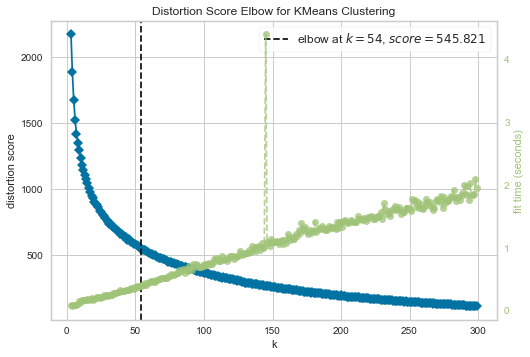

In [23]:
k_means = KMeans()
visualizer = KElbowVisualizer(k_means, k=(3, 300))
visualizer.fit(data.sample(10**3))
visualizer.show()

In [12]:
# On rentre le nombre de clusters donnés par la méthode elbow : 55 
# (on en rajoute un étant donné l'échantillon et la différence d'amplitude des abv dans les données réelles)
k_means = KMeans(n_clusters=55)
k_means.fit(data) #K-means training
k_means.predict(data)

array([40, 47, 40, ..., 46, 10,  7])

In [13]:
# On ajoute une colonne au dataframe avec pour chaque avis le cluster qui lui correspond
df_subj_abv['cluster_all'] = k_means.labels_
cluster_name.append('cluster_all')

### Clustering uniquement sur les avis subjectifs

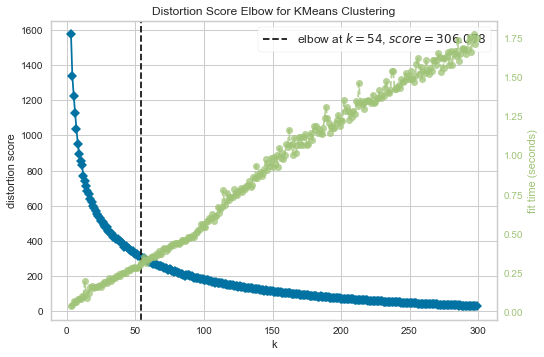

In [20]:
k_means = KMeans()
visualizer = KElbowVisualizer(k_means, k=(3, 300))
visualizer.fit(data[['look', 'smell', 'taste', 'feel']].sample(10**3))
visualizer.show()

In [14]:
# On rentre le nombre de clusters donnés par la méthode elbow : 54
k_means = KMeans(n_clusters = 54)
k_means.fit(data[['look', 'smell', 'taste', 'feel']]) #K-means training
k_means.predict(data[['look', 'smell', 'taste', 'feel']])

array([40, 22, 40, ..., 48, 50, 13])

In [15]:
df_subj_abv['cluster_subj'] = k_means.labels_
cluster_name.append('cluster_subj')

### Clustering sur l'abv
On va utilser directement la colonne abv de df_ml, déjà parce qu'on a un seul feature et afin de donner plus de poid aux valeur importantes d'abv.

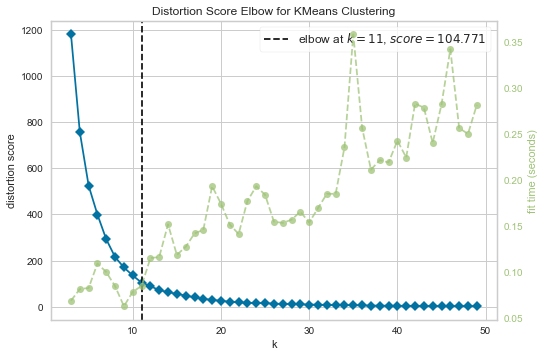

In [34]:
visualizer = KElbowVisualizer(k_means, k=(3, 50))
visualizer.fit(df_ml[['abv']].sample(10**3))
visualizer.show()

In [16]:
# On rentre le nombre de clusters donnés par la méthode elbow : 11
k_means = KMeans(n_clusters = 11)
k_means.fit(df_ml[['abv']]) #K-means training
k_means.predict(data[['abv']])

array([7, 7, 7, ..., 7, 7, 7])

In [19]:
df_ml['cluster_abv'] = k_means.labels_
cluster_name.append('cluster_abv')

### Réalisation d'une matrice de corrélation 

On veut réaliser de nouveaux clusterings portant sur moins de features à la fois. Puisque l'on souhaite à terme associer des bières similaires, et qu'on a déjà fait nos premiers clusterings "globaux" sur tous les features à la fois, pn va se focaliser uniquement sur les features qui sont corrélés à, disons, plus de 70 % et à moins de 95%. 

Ainsi, on espère pouvoir accorder plus d'importance aux similitudes entre ces features, qui se complètent mutuellement sans pour autant pouvoir totalement s'expliquer les uns les autres.

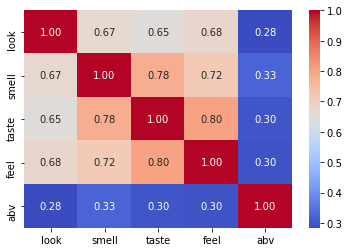

In [23]:
sns.heatmap(df_subj_abv[['look', 'smell', 'taste', 'feel', 'abv']].corr(), cmap='coolwarm', annot=True, fmt=".2f")

Vu le graphe des corrélations ci-dessus, on va essayer de rassembler en cluster simplement à partir des colonnes : 
- feel, taste et smell
- taste et smell
- taste et feel

Pour le reste, on sera en dessous de 70% de corrélation et cela ne semble pas indispensable dans un premier temps.

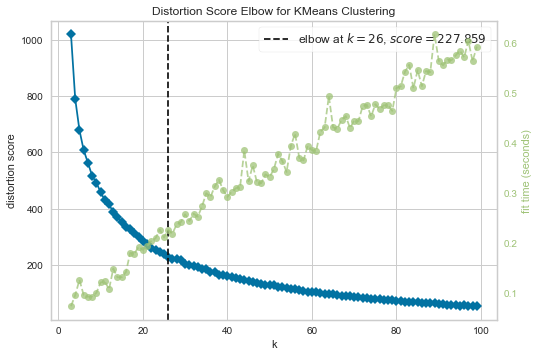

In [29]:
visualizer = KElbowVisualizer(k_means, k=(3, 100))
visualizer.fit(data[['feel', 'taste', 'smell']].sample(10**3))
visualizer.show()

In [20]:
# On rentre le nombre de clusters donnés par la méthode elbow : 26
k_means = KMeans(n_clusters = 26)
k_means.fit(data[['feel', 'taste', 'smell']]) #K-means training
k_means.predict(data[['feel', 'taste', 'smell']])
df_subj_abv['cluster_nolook'] = k_means.labels_
cluster_name.append('cluster_nolook')

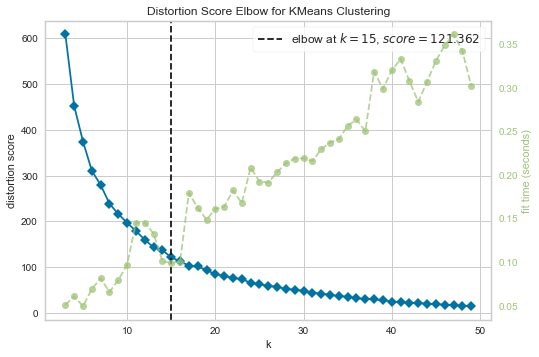

In [32]:
visualizer = KElbowVisualizer(k_means, k=(3, 50))
visualizer.fit(data[['feel', 'taste']].sample(10**3))
visualizer.show()

C:\Users\sim13\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


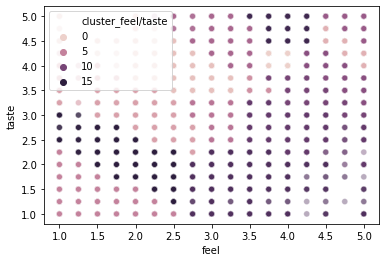

In [21]:
#15
k_means = KMeans(n_clusters = 15)
k_means.fit(data[['feel', 'taste']]) #K-means training
k_means.predict(data[['feel', 'taste']])
df_subj_abv['cluster_feel/taste'] = k_means.labels_
cluster_name.append('cluster_feel/taste')

# On représente ce clustering à l'aide d'un scatterplot car cette visualisation en 2S a du sens avec 2 features
p = sns.scatterplot(data=df_subj_abv.sample(10**6), x="feel", y = "taste", hue = "cluster_feel/taste",alpha = 0.4)

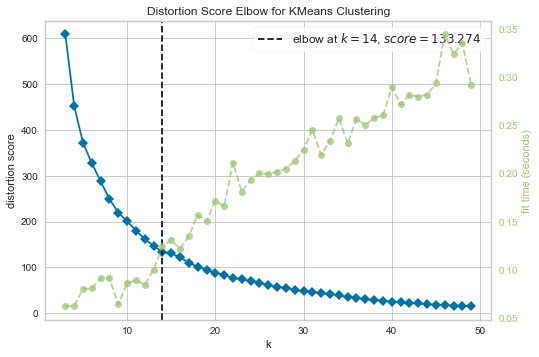

In [33]:
visualizer = KElbowVisualizer(k_means, k=(3, 50))
visualizer.fit(data[['taste', 'smell']].sample(10**3))
visualizer.show()
# A peu près 10 min d'éxécution

In [22]:
#14
k_means = KMeans(n_clusters = 14)
k_means.fit(data[['taste', 'smell']]) #K-means training
k_means.predict(data[['taste', 'smell']])
df_subj_abv['cluster_taste/smell'] = k_means.labels_
cluster_name.append('cluster_taste/smell')

### Téléchargement des clusters K-mean en local

Puisque l'exécution de chacun de ces algorithmes a été particulièrement longue, on télécharge une bonne fois pour toutes les données en local afin de n'avoir plus qu'à les ouvrir ultérieurement.

In [23]:
df_subj_abv.to_csv(r'C:\Users\sim13\OneDrive\Documents\Projet_python_2A\data_all_clusters.csv')
df_ml.to_csv(r'C:\Users\sim13\OneDrive\Documents\Projet_python_2A\data_abv_clusters.csv')

## Clustering avec CAH 

On va désormais s'intéresser à un nouvel algorithme de clustering dit hiérarchique ; le CAH. 

Son principal avantage par rapport au K-mean, c'est qu'il effectue le clustering de manière hiérarchique, c'est-à-dire que chaque cluster est construit l'un après l'autre, ce qui permet de prendre en compte les clusters précédents dans la construction des suivants. 

Cette démarche s'illustre avec un arbre ou dendogramme que le CAH va d'ailleurs construire.

Le principal inconvénient de cette méthode, c'est qu'elle ne s'applique par aux 'grands ensembles de données'. On s'attend donc à rencontrer un problème dans la mise de place.

In [7]:
from sklearn.cluster import AgglomerativeClustering

In [22]:
df_subj_abv

,beer_name,beer_style,abv,brewery_id,brewery_name,look,smell,taste,feel
id,,,,,,,,,
8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.00,3.50,4.00,3.50
8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.50,3.00,3.50,4.00
8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.00,3.50,4.00,3.50
8677,Red Leaf Strong Ale,American Strong Ale,8.6,2199,Main Street Brewery,4.00,4.00,4.00,4.50
8749,Pleasanton Pale Ale,American Pale Ale (APA),5.3,2199,Main Street Brewery,4.00,3.50,3.50,4.00
...,...,...,...,...,...,...,...,...,...
177750,Goldcrest 51,American Adjunct Lager,4.9,40829,Goldcrest Brewing Company,3.50,3.50,4.00,3.50
177750,Goldcrest 51,American Adjunct Lager,4.9,40829,Goldcrest Brewing Company,4.00,4.00,4.00,4.00
177750,Goldcrest 51,American Adjunct Lager,4.9,40829,Goldcrest Brewing Company,3.25,3.25,3.25,3.25


In [25]:
CAH_classifier = AgglomerativeClustering(n_clusters = 5)
y_pred = CAH_classifier.fit(df_subj_abv[['abv']])

MemoryError: Unable to allocate 89.4 TiB for an array with shape (12289863152115,) and data type float64

## Impossibilité d'utilisation du CAH

L'erreur qu'on obtient, "Memory Error", atteste que l'on ne peut pas utiliser le CAH pour notre base de données, beaucoup trop volumineuse. 

On pourrait éventuellement utiliser une méthode mixte de CAH et K-mean, mais ne sachant pas réellement ce que l'on souhaite obtenir en termes de clustering, on va pour l'instant se satisfaire du K-mean pour éventuellement revenir, plus tard, à cette piste.

## Clustering avec DBSCAN
Nous allons tester une troisième méthode de clustering, le DBSCAN, dont nous décrivons les principales caractéristiques.


Avantages : 
- Pas besoin de définir le nombres de clusters (la méthode du coude pour K-mean est longue avec autant de données et cet avantage pourrait s'avérer déterminant)
- Cette méthode peut repérer le bruit dans les données, par exemple si quelques bières sont vraiment très originales (par exemple celles avec un abv vraiment élevé, une odeur particulièrement pestinentielle...), celles-ci seront identifiées par DBSCAN et placée dans un cluster particulier qui regrouperait ces bières originales.

Cet algorithme possède 2 paramètres qu'il nous faut optimiser avant de modéliser notre clustering.
- epsilon : le rayon du cercle autour de chaque point. Sert à imposer une certaine densité au sein de chaque cluster. On peut le déterminer avec un graphe K-distance, dont le point coude donne la valeur de epsilon. 
- minPoint : le nombre minimum de point qui doivent appartenir au cercle de rayon epsilon afin de définir un point Core (coeur) du cluster. Il faut au minimum que minPoint > nombre de dimensions du dataset + 1

In [1]:
# Méthode des voisins pour déterminer epsilon 

data_subj = data[['look', 'smell', 'taste', 'feel']]

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_subj.sample(10**5))
distances, indices = nbrs.kneighbors(data_subj)

NameError: name 'data' is not defined

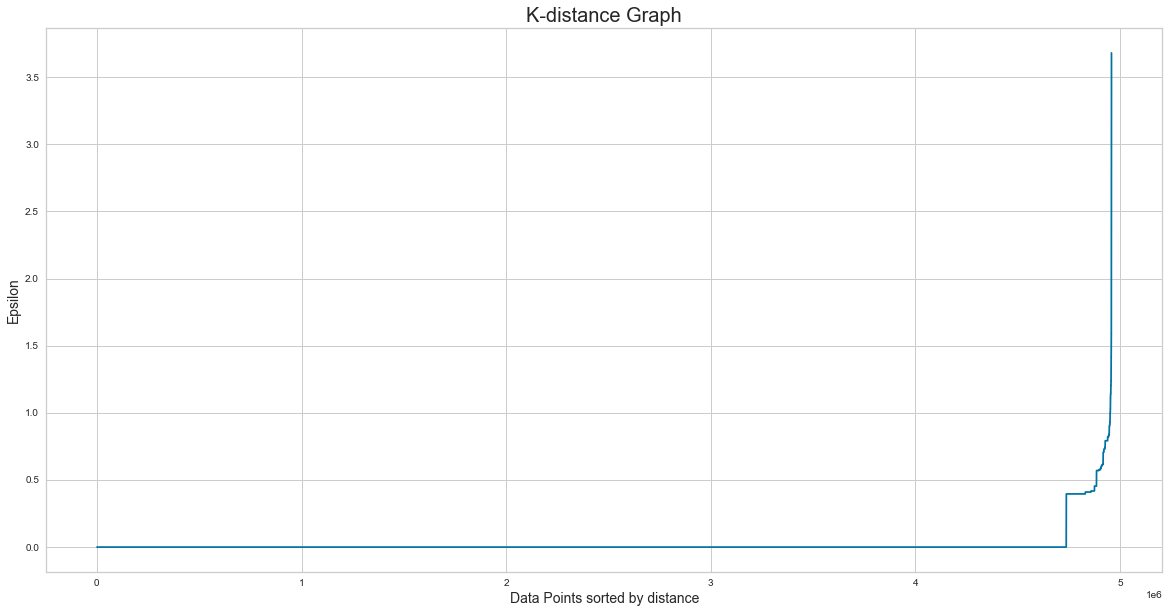

In [20]:
distances = np.sort(distances, axis=0)
distances = distances[:,1] # On fit avec le training set donc le plus proche voisin est lui-même
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

On procède en échantillonant, l'algorithme étant trop lent pour les 7 millions de lignes
- epsilon = 0.4 pour 100 000 données


### Choix des paramètres de DBSCAN
- On choisit min_sample = 8 de manière quelque peu arbitraire en respectant la condition décrite plus haut.


In [ ]:
from sklearn.cluster import DBSCAN
data_subj = data[['look', 'smell', 'taste', 'feel']]

dbscan=DBSCAN(eps = 0.3, min_samples = 8)
dbscan.fit(data_subj)

In [ ]:
df_subj_abv['DBSCAN_opt_labels']=dbscan_opt.labels_
df_subj_abv['DBSCAN_opt_labels'].value_counts()

### Juste pour abv 

ne marche pas non plsutrop long

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_ml[['abv']])
distances, indices = nbrs.kneighbors(df_ml[['abv']])
distances = np.sort(distances, axis=0)
distances = distances[:,1] # On fit avec le training set donc le plus proche voisin est lui-même
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN(eps = 0.7, min_samples = 5)
dbscan.fit(df_subj_abv[['abv']])

## Impossibilité d'utilisation du DBSCAN

J'arrête l'algorithme au bout de 6h, sans résultat obtenu.

# Bilan des algorithmes de clustering
On a un très grand nombre de données et ainsi, seul l'algorithme de K-mean sort du lot en nous proposant une répartitions en clusters rapide et fiable. 
- Le clustering hiérarchique est à exclure car la memoryerror que l'on obtient dès que l'on arrive vers 10^5 données est irrémédiable pour l'instant.
- Le DBSCAN a une complexité plus importante que le K-mean, et il faut le laisser tourner au moins plus de 6h pour un clustering, ce qui est vraiment trop long (j'ai arrêté le noyau au bout de 6h, faute de résultat). On pourra réitérer un essai si le Kmean ne donne vraiment pas de satisfaction.